# Setup

**Information about the different models which might be useful when writing the paper**
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from pathlib import Path

In [2]:
PATH = "../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory640000.csv"
MEMORY = 640000
DF = pd.read_csv(PATH)

In [3]:
MODELS = {
    "clip-vit-base-patch16": "CLIP ViT-B/16",
    "dino_vitb16": "DINO ViT-B/16",
    "dinov2_vitb14": "DINOv2 ViT-B/14",
    "dinov3-vitb16-pretrain-lvd1689m": "DINOv3 ViT-B/16",
    "C-RADIOv2-B": "C-RADIOv2 ViT-B/16-CPE",
    "siglip2-base-patch16-512": "SigLIP B/16-512",
    "tips-b14" : "TIPS ViT-B/14-HR", # (448)
}
PREFIXES = {
    "clip-vit-base-patch16": "clip",
    "dino_vitb16": "dino",
    "dinov2_vitb14": "dinov2",
    "dinov3-vitb16-pretrain-lvd1689m": "dinov3",
    "C-RADIOv2-B": "radio",
    "siglip2-base-patch16-512": "siglip2",
    "tips-b14": "tips",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "dinov3-vitb16-pretrain-lvd1689m": "#17becf",
    "C-RADIOv2-B": "#d62728",
    "siglip2-base-patch16-512": "#9467bd",
    "tips-b14": "#8c564b",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [4]:
DF.head()

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
0,12094740,C-RADIOv2-B,0_30_60_90,0,0.668,0.138,0.965,0.651,0.668,0.644,...,0.695,0.884,0.528,0.682,0.742,0.858,768,4,512,16
1,12094740,C-RADIOv2-B,0_30_60_90,15,0.643,0.152,0.963,0.648,0.654,0.600,...,0.662,0.875,0.451,0.693,0.725,0.852,768,4,512,16
2,12094740,C-RADIOv2-B,0_30_60_90,30,0.679,0.136,0.967,0.690,0.689,0.642,...,0.690,0.876,0.524,0.739,0.728,0.861,768,4,512,16
3,12094740,C-RADIOv2-B,0_30_60_90,45,0.659,0.146,0.966,0.693,0.651,0.609,...,0.686,0.869,0.525,0.737,0.718,0.862,768,4,512,16
4,12094740,C-RADIOv2-B,0_30_60_90,60,0.685,0.128,0.968,0.702,0.688,0.613,...,0.698,0.861,0.556,0.744,0.721,0.864,768,4,512,16


In [5]:
def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str):
    """
    Plot experiment A result for specified class.
    Class is either None (all classes) or a list of class numbers
    """
    
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        # remove background class (0) from classes
        classes = [c for c in classes if c != 0]
    
    class_indices = [CLASS_TO_INDEX[c] for c in classes]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=200)
    axes = axes.flatten()

    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        
        train_bins_set = set(map(int, train_bins.split("_")))
                
        for model in MODELS.keys():
            df = DF[DF["model"] == model]
            df = df[df["train_bins"] == train_bins].sort_values("val_bin")

            # only get the jacX values for classes X
            df["jac_mean"] = df[[f"jac{c}" for c in class_indices]].mean(axis=1)
            df["jac_std"] = df[[f"jac{c}" for c in class_indices]].std(axis=1)

            x_values = df["val_bin"]
            y_values = df["jac_mean"].values
            y_error = df["jac_std"].values

            if len(x_values) == 0 or len(y_values) == 0:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # plot the data
            for j, (x_value, y_value) in enumerate(zip(x_values, y_values)):
                # Use asterisk marker if bin is trained on, circle for others
                marker = 'x' if int(x_value) in train_bins_set else 'o'
                ax.scatter(x_value, y_value, label=f"{MODELS[model]}" if j == 1 else "", 
                           color=COLORS[model], marker=marker, s=50, zorder=2)

            # include error bars
            ax.errorbar(x_values, y_values, yerr=y_error, fmt='none', color=COLORS[model], 
                        capsize=5, elinewidth=0)
            
        ax.set_xticks(XTICKS)
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Training bin(s) = {', '.join(train_bins.split('_'))} ({difficulty})")
        # ax.set_title(f"Extreme difficulty, class: ceiling lamp", fontsize=10)
        ax.set_xlabel("Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True)

    axes[0].legend()
    plt.suptitle(f"Experiment A results ({extratitle})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Plots

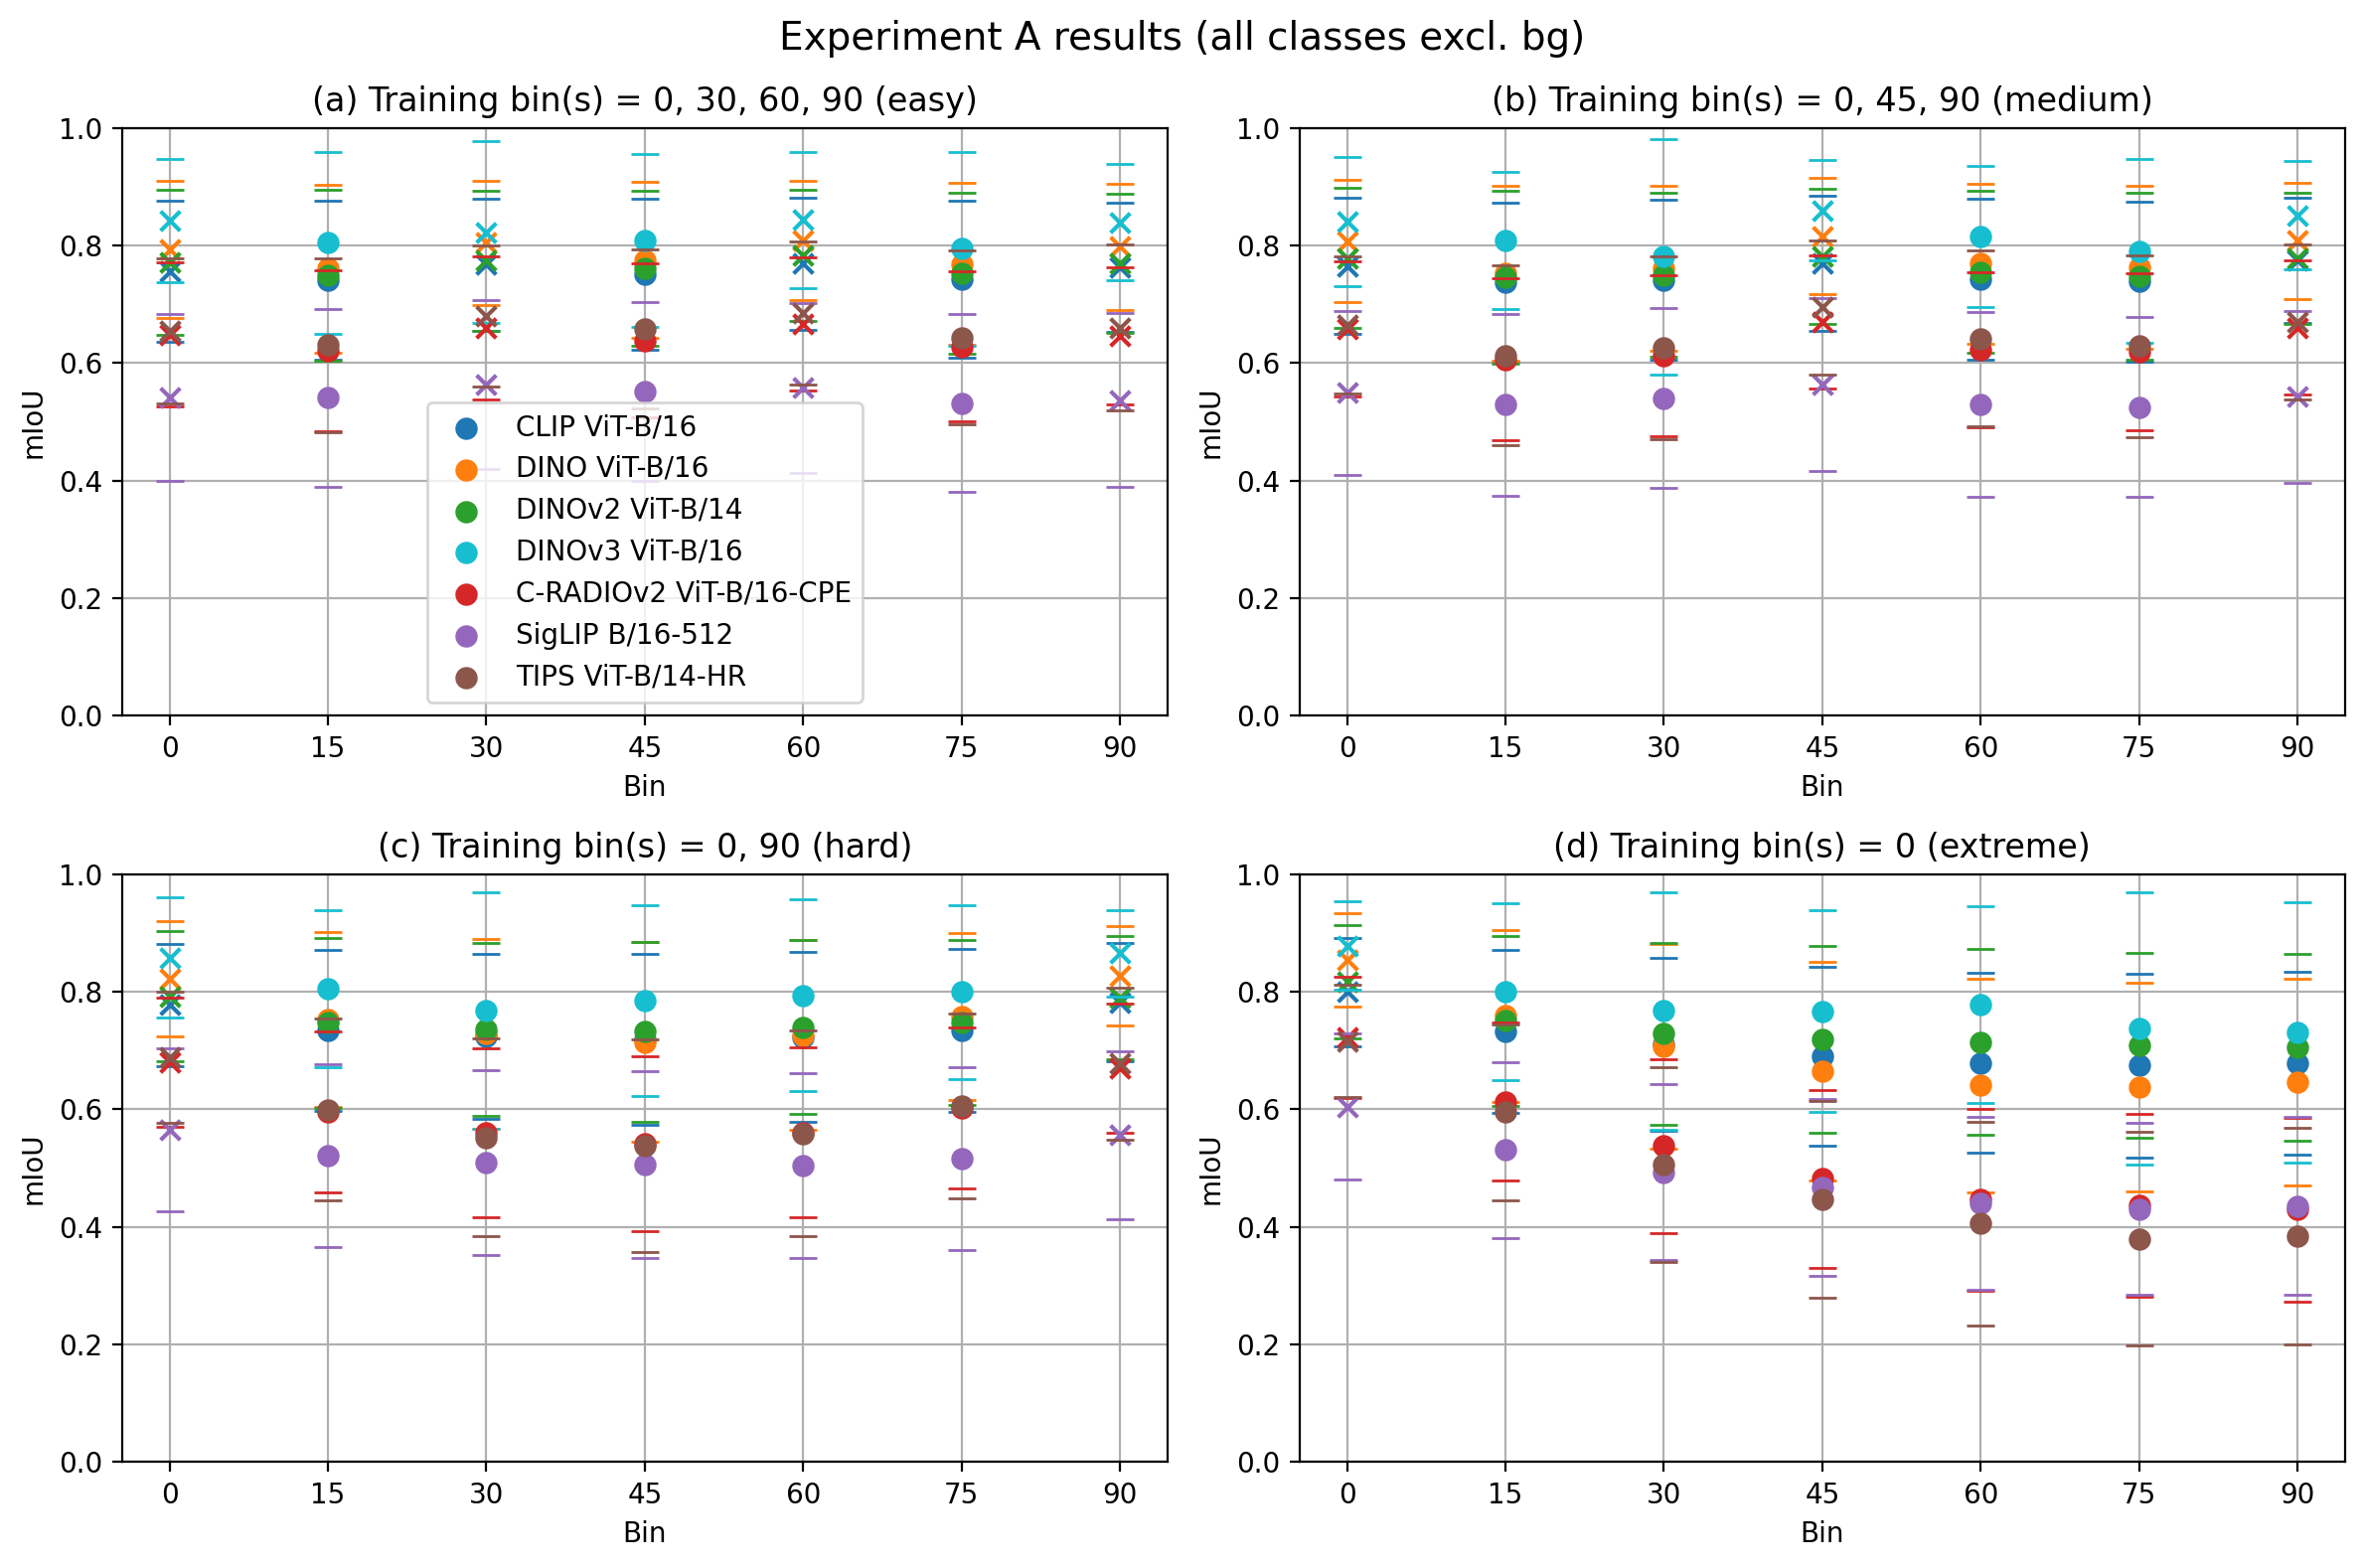

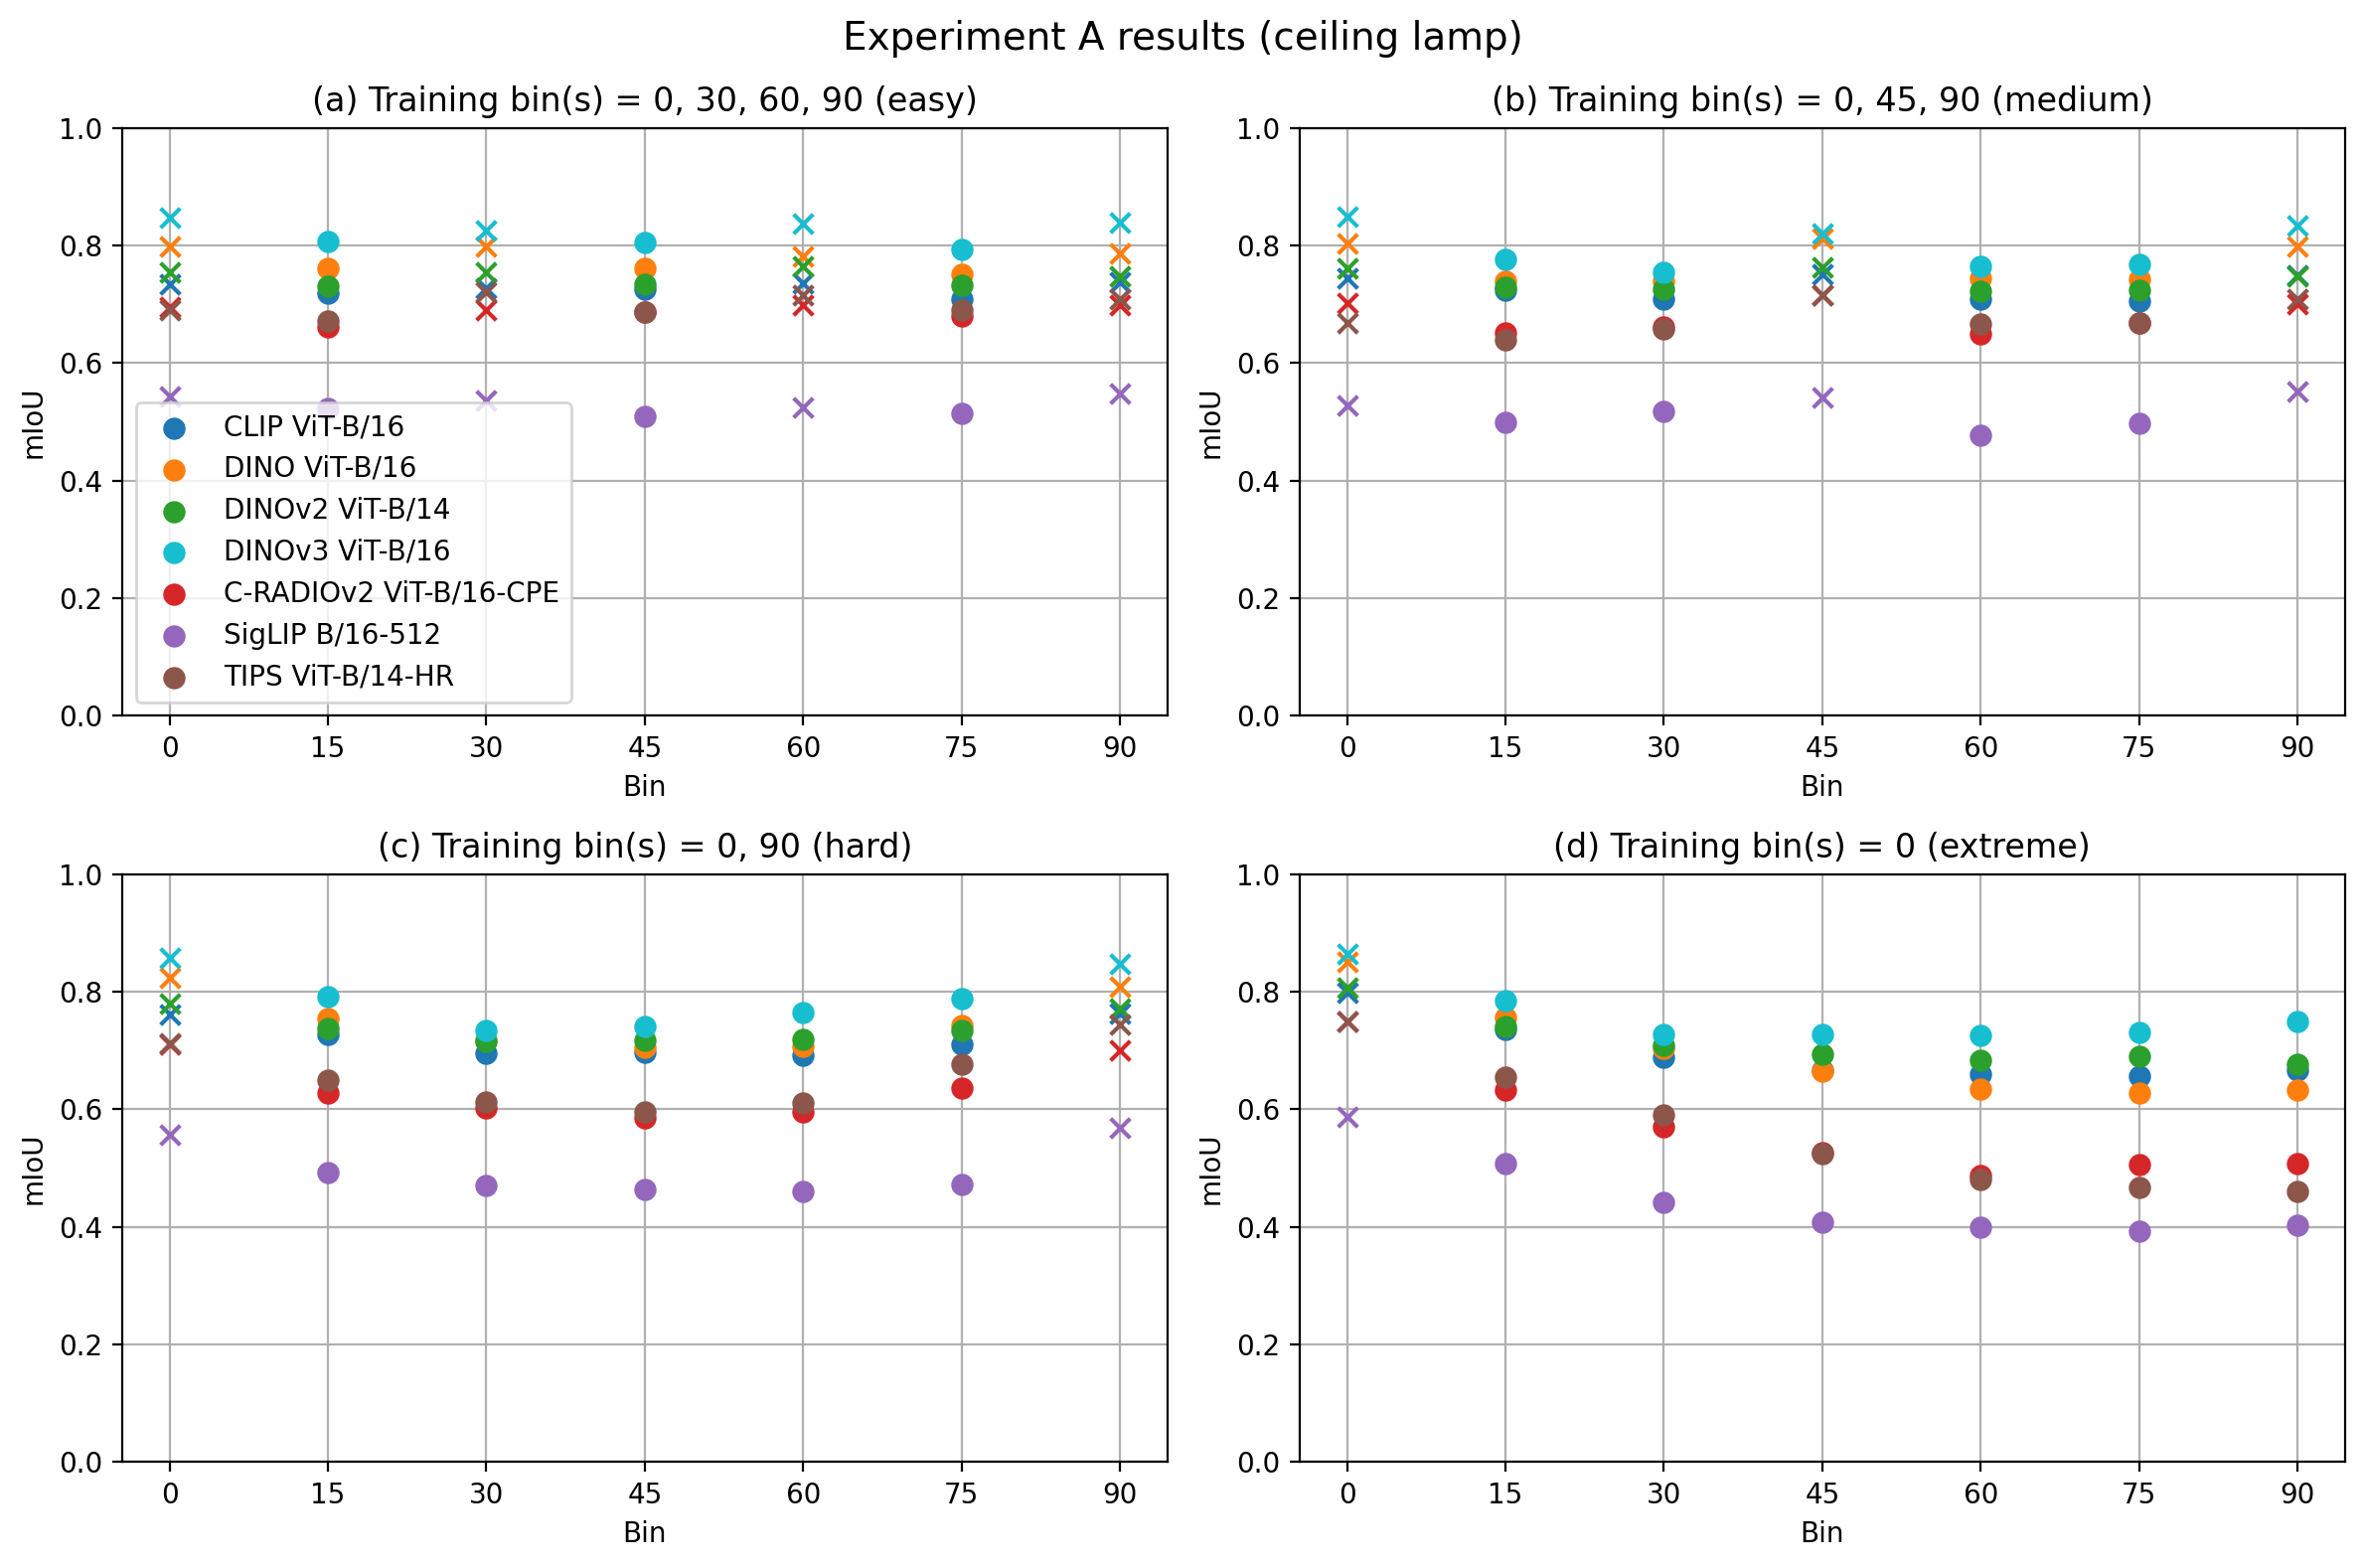

In [6]:
# plot figure with all classes included
plot_exp_a(None, False, extratitle="all classes excl. bg")
# plot_exp_a(None, True, extratitle="all classes incl. bg")

# plot specific classes
plot_exp_a([113], False, extratitle=CLASS_TO_NAME[113])  # ceiling lamp

In [7]:
job_id = str(DF['job_id'].iloc[0])
model = DF['model'].iloc[0]
prefix = PREFIXES.get(model)
if prefix is None:
    raise ValueError(f"Unknown model name: {model}")

log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")

# Read last 15 lines after JOB STATISTICS
def tail_log_after_statistics(path, num_lines=15):
    if not path.exists():
        return f"Log file not found: {path}"
    
    with open(path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            return ''.join(lines[start_idx:start_idx + num_lines])
        except StopIteration:
            return "JOB STATISTICS not found in log file."

# Output result
log_tail = tail_log_after_statistics(log_path)
print(log_tail)


JOB STATISTICS
Job ID: 12094740
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-11:02:33
CPU Efficiency: 13.87% of 24-22:33:36 core-walltime
Job Wall-clock time: 08:18:48
Memory Utilized: 203.63 GB
Memory Efficiency: 42.42% of 480.00 GB (480.00 GB/node)



In [8]:
# Get all unique (job_id, model) pairs
unique_jobs = DF[['job_id', 'model']].drop_duplicates()

# Function to extract JOB STATISTICS section
def print_job_statistics(job_id, model):
    prefix = PREFIXES.get(model)
    if not prefix:
        print(f"⚠️ Skipping unknown model: {model}")
        return
    
    log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")
    print(f"\n=== JOB STATISTICS for job_id: {job_id}, model: {model} ===")
    
    if not log_path.exists():
        print(f"⚠️ Log file not found: {log_path}")
        return

    with open(log_path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            for line in lines[start_idx:]:
                print(line, end='')  # already includes newline
        except StopIteration:
            print("⚠️ 'JOB STATISTICS' section not found in log.")

# Loop and print
print(f"The following JOB STATISTICS are for memory: {MEMORY}")
for _, row in unique_jobs.iterrows():
    job_id = str(row['job_id'])
    model = row['model']
    print_job_statistics(job_id, model)


The following JOB STATISTICS are for memory: 640000

=== JOB STATISTICS for job_id: 12094740, model: C-RADIOv2-B ===
JOB STATISTICS
Job ID: 12094740
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-11:02:33
CPU Efficiency: 13.87% of 24-22:33:36 core-walltime
Job Wall-clock time: 08:18:48
Memory Utilized: 203.63 GB
Memory Efficiency: 42.42% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12094724, model: clip-vit-base-patch16 ===
JOB STATISTICS
Job ID: 12094724
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-10:39:36
CPU Efficiency: 13.75% of 25-01:12:00 core-walltime
Job Wall-clock time: 08:21:00
Memory Utilized: 177.58 GB
Memory Efficiency: 37.00% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12094741, model: siglip2-base-patch16-512 ===
JOB STATISTICS
Job ID: 12094741
Cluster: snellius
User/Group: scur0542/s

## Table

In [9]:
df = DF.copy()

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

,model,easy,medium,hard,extreme
0,CLIP ViT-B/16,0.745 ± 0.132,0.740 ± 0.136,0.727 ± 0.141,0.694 ± 0.150
1,DINO ViT-B/16,0.768 ± 0.137,0.761 ± 0.141,0.736 ± 0.156,0.676 ± 0.173
2,DINOv2 ViT-B/14,0.754 ± 0.138,0.750 ± 0.142,0.740 ± 0.147,0.721 ± 0.155
3,DINOv3 ViT-B/16,0.802 ± 0.155,0.799 ± 0.148,0.790 ± 0.162,0.763 ± 0.191
4,C-RADIOv2 ViT-B/16-CPE,0.629 ± 0.132,0.615 ± 0.135,0.572 ± 0.142,0.491 ± 0.150
5,SigLIP B/16-512,0.541 ± 0.152,0.531 ± 0.154,0.511 ± 0.157,0.466 ± 0.149
6,TIPS ViT-B/14-HR,0.644 ± 0.144,0.628 ± 0.153,0.571 ± 0.167,0.453 ± 0.170


In [10]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
CLIP ViT-B/16 & 0.745 ± 0.132 & 0.740 ± 0.136 & 0.727 ± 0.141 & 0.694 ± 0.150 \\
DINO ViT-B/16 & 0.768 ± 0.137 & 0.761 ± 0.141 & 0.736 ± 0.156 & 0.676 ± 0.173 \\
DINOv2 ViT-B/14 & 0.754 ± 0.138 & 0.750 ± 0.142 & 0.740 ± 0.147 & 0.721 ± 0.155 \\
DINOv3 ViT-B/16 & 0.802 ± 0.155 & 0.799 ± 0.148 & 0.790 ± 0.162 & 0.763 ± 0.191 \\
C-RADIOv2 ViT-B/16-CPE & 0.629 ± 0.132 & 0.615 ± 0.135 & 0.572 ± 0.142 & 0.491 ± 0.150 \\
SigLIP B/16-512 & 0.541 ± 0.152 & 0.531 ± 0.154 & 0.511 ± 0.157 & 0.466 ± 0.149 \\
TIPS ViT-B/14-HR & 0.644 ± 0.144 & 0.628 ± 0.153 & 0.571 ± 0.167 & 0.453 ± 0.170 \\
\bottomrule
\end{tabular}



# Experiment B

In [11]:
df_extreme = DF[DF["train_bins"] == "0"]  # extreme difficulty
df_extreme.head(10)

,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac10,jac11,jac12,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size
126,12094740,C-RADIOv2-B,0,0,0.737,0.114,0.971,0.752,0.719,0.758,...,0.749,0.914,0.644,0.760,0.767,0.877,768,4,512,16
127,12094740,C-RADIOv2-B,0,15,0.635,0.151,0.962,0.618,0.640,0.569,...,0.632,0.861,0.449,0.698,0.714,0.857,768,4,512,16
128,12094740,C-RADIOv2-B,0,30,0.564,0.172,0.957,0.501,0.594,0.417,...,0.570,0.789,0.356,0.617,0.672,0.833,768,4,512,16
129,12094740,C-RADIOv2-B,0,45,0.512,0.182,0.954,0.436,0.523,0.316,...,0.526,0.688,0.299,0.547,0.649,0.821,768,4,512,16
130,12094740,C-RADIOv2-B,0,60,0.478,0.189,0.953,0.411,0.508,0.260,...,0.488,0.629,0.260,0.495,0.629,0.805,768,4,512,16
131,12094740,C-RADIOv2-B,0,75,0.469,0.192,0.952,0.418,0.499,0.267,...,0.506,0.648,0.270,0.449,0.610,0.799,768,4,512,16
132,12094740,C-RADIOv2-B,0,90,0.462,0.194,0.951,0.434,0.480,0.278,...,0.507,0.654,0.273,0.441,0.592,0.802,768,4,512,16
133,12094724,clip-vit-base-patch16,0,0,0.810,0.096,0.974,0.869,0.877,0.826,...,0.799,0.875,0.745,0.888,0.875,0.908,768,4,512,16
134,12094724,clip-vit-base-patch16,0,15,0.747,0.142,0.969,0.833,0.830,0.728,...,0.735,0.856,0.560,0.879,0.857,0.896,768,4,512,16
135,12094724,clip-vit-base-patch16,0,30,0.727,0.151,0.968,0.822,0.811,0.685,...,0.688,0.845,0.512,0.876,0.851,0.891,768,4,512,16


In [12]:
def plot_exp_b(normalize=False):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = df_extreme[df_extreme["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


## Plots

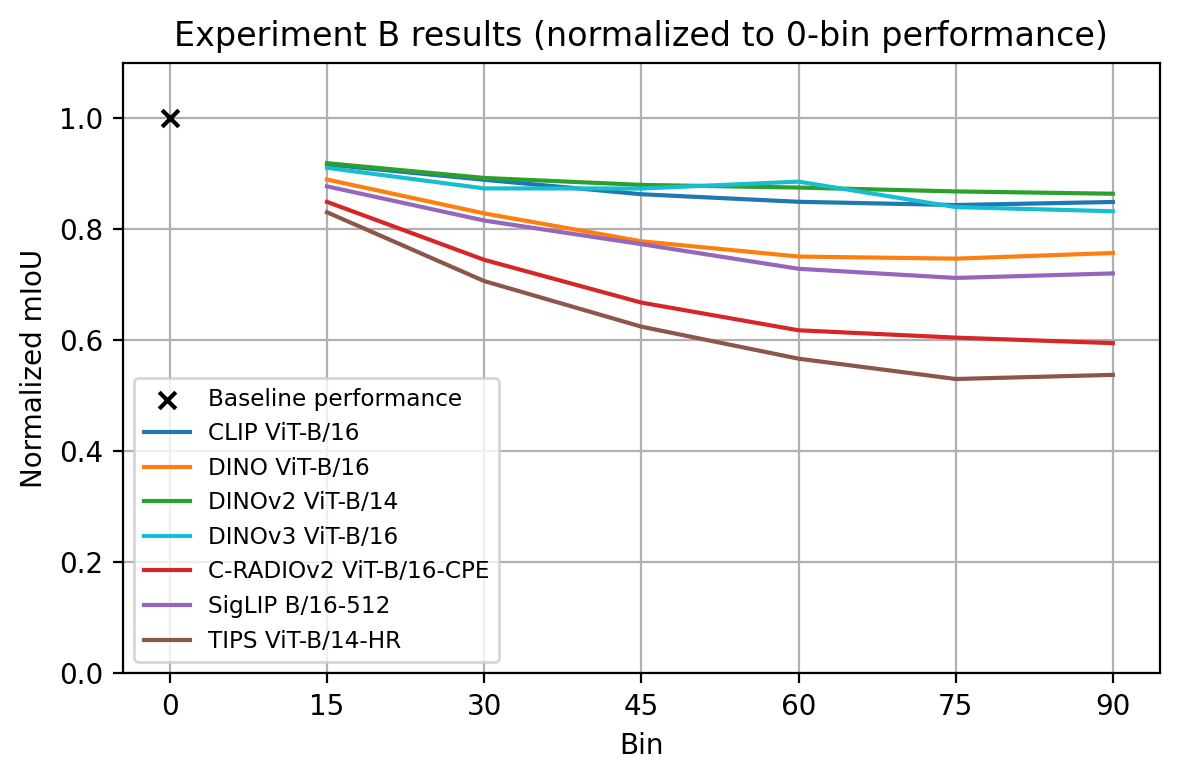

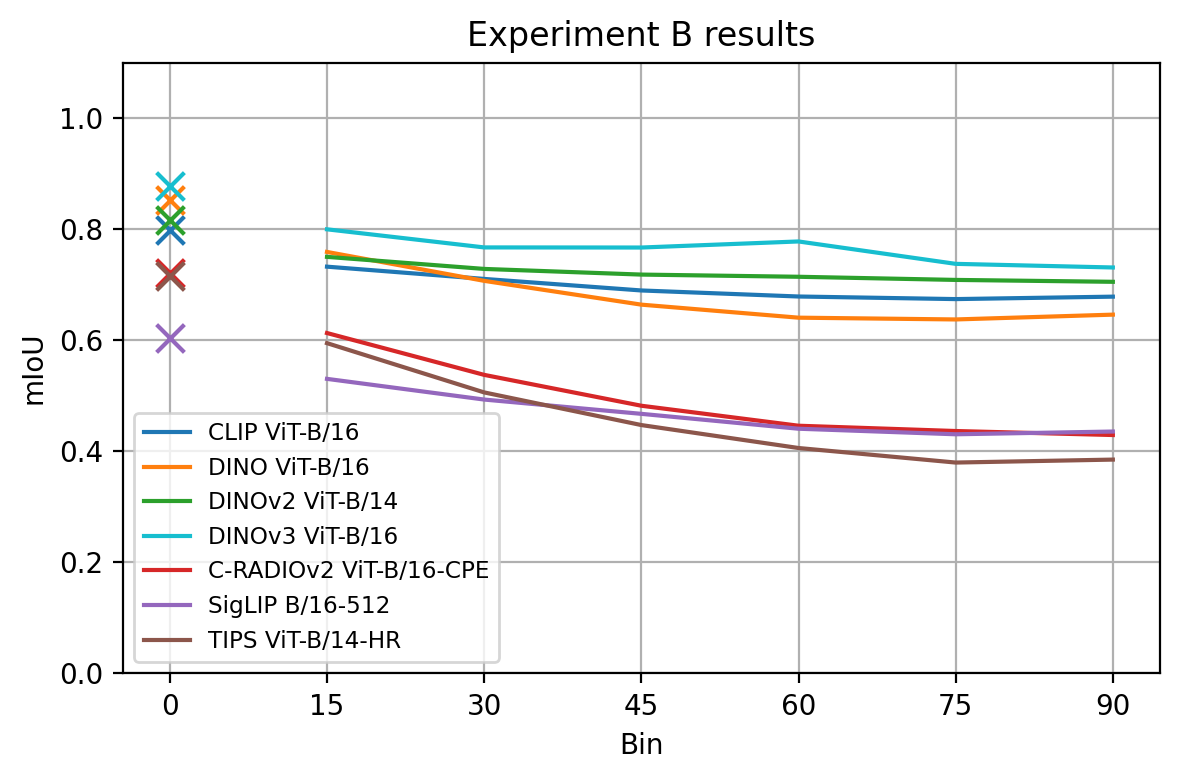

In [13]:
plot_exp_b(normalize=True)
plot_exp_b(normalize=False)

## Table

In [14]:
DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
final_df = None
threshold = 0.05

for model in MODELS.keys():
    df = df_extreme[df_extreme["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)
    # delta is difference between jac norm and shifted jac norm
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if final_df is None:
        final_df = df.copy()
    else:
        final_df = pd.concat([final_df, df], ignore_index=True)

final_df

# To find a breaking point: check the last column called delta, compare the delta with the threshold
# The first delta exceeding the treshold is the breaking point


,job_id,model,train_bins,val_bin,jac_mean,jac_std,jac0,jac1,jac2,jac3,...,jac13,jac14,jac15,d_model,batch_size,input_size,patch_size,jac_norm,jac_norm_prev,delta
0,12094724,clip-vit-base-patch16,0,15,0.747,0.142,0.969,0.833,0.830,0.728,...,0.879,0.857,0.896,768,4,512,16,0.922222,1.000000,-0.077778
1,12094724,clip-vit-base-patch16,0,30,0.727,0.151,0.968,0.822,0.811,0.685,...,0.876,0.851,0.891,768,4,512,16,0.897531,0.922222,-0.024691
2,12094724,clip-vit-base-patch16,0,45,0.707,0.158,0.968,0.807,0.770,0.655,...,0.854,0.855,0.895,768,4,512,16,0.872840,0.897531,-0.024691
3,12094724,clip-vit-base-patch16,0,60,0.697,0.159,0.969,0.792,0.766,0.641,...,0.832,0.856,0.893,768,4,512,16,0.860494,0.872840,-0.012346
4,12094724,clip-vit-base-patch16,0,75,0.693,0.162,0.969,0.786,0.775,0.642,...,0.841,0.857,0.889,768,4,512,16,0.855556,0.860494,-0.004938
5,12094724,clip-vit-base-patch16,0,90,0.697,0.161,0.969,0.782,0.779,0.648,...,0.858,0.856,0.888,768,4,512,16,0.860494,0.855556,0.004938
6,12094728,dino_vitb16,0,15,0.773,0.146,0.976,0.852,0.855,0.737,...,0.900,0.898,0.928,768,4,512,16,0.897793,1.000000,-0.102207
7,12094728,dino_vitb16,0,30,0.724,0.175,0.974,0.803,0.806,0.639,...,0.873,0.888,0.924,768,4,512,16,0.840883,0.897793,-0.056911
8,12094728,dino_vitb16,0,45,0.684,0.189,0.973,0.769,0.736,0.552,...,0.839,0.887,0.930,768,4,512,16,0.794425,0.840883,-0.046458
9,12094728,dino_vitb16,0,60,0.662,0.188,0.973,0.737,0.722,0.501,...,0.803,0.884,0.927,768,4,512,16,0.768873,0.794425,-0.025552
